In [4]:
'''
SSLGAN on CIFAR10 using Keras

'''
from matplotlib import pyplot
import numpy as np
from numpy import expand_dims
from numpy.random import randint
from numpy.random import randn

import time
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Add
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout, Lambda, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.datasets.cifar10 import load_data
from keras import backend
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import os

path="SSLGAN_CIFAR10_L1L2_FM/"
os.makedirs(path, exist_ok=True)

# custom activation function
def custom_activation(output):
    logexpsum = K.sum(K.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

# load the images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = trainX #expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    #print(X.shape, trainy.shape)
    return [X, trainy]

# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
    X, y = dataset
   
    X_list, y_list = list(), list()
    n_per_class = int(n_samples / n_classes)
    for i in range(n_classes):
        # get all images for this class
        X_with_class = X[np.squeeze(y == i)]
        # choose random instances
        ix = randint(0, len(X_with_class), n_per_class)
        # add to list
        [X_list.append(X_with_class[j]) for j in ix]
        [y_list.append(i) for j in ix]
    return np.asarray(X_list), np.asarray(y_list)

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    z_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = z_input.reshape(n_samples, latent_dim)
    return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict(z_input)
    # create class labels
    y = np.zeros((n_samples, 1))
    return images, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # evaluate the classifier model
    X, y = dataset
    _, acc = c_model.evaluate(X, y, verbose=0)
    print('Classifier Accuracy: %.3f%%' % (acc * 100))
    # save the generator model
    filename2 = 'g_model_%04d.h5' % (step+1)
    g_model.save(filename2)
    # save the classifier model
    filename3 = 'c_model_%04d.h5' % (step+1)
    c_model.save(filename3)
    print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )


In [5]:

class SSLGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1, n_classes=10):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.n_classes = n_classes
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model
        self.CM = None  # classifier model
        self.GM = None  #The generator
        self.DM_features = None
        self.DM_tail = None
        
    def save(self, file_path):
        self.AM.save(file_path)
        
    def load(self, file_path):
        self.AM = tf.keras.models.load_model(file_path)
        self.GM = Model(self.AM.input, self.AM.layers[-2].output) 
        self.DM = self.AM.layers[-1]
        last_prev_layer =self.DM.layers[-2]
        c_out_layer = Activation('softmax')(last_prev_layer.output)
        self.CM = Model(self.DM.input,c_out_layer )
        
    # (W−F+2P)/S+1
    def discriminator(self): #create classifier and discriminator
        if self.DM and self.CM :
            return self.CM, self.DM, self.DM_features, self.DM_tail
        
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        in_image = Input(shape=input_shape)
        x = Conv2D(depth*1, 3, strides=2, padding='same')(in_image)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(dropout)(x)
       
        x = Conv2D(depth*2, 3, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(dropout)(x)
        
        x = Conv2D(depth*4, 3, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(dropout)(x)

        x = Conv2D(depth*8, 3, strides=1, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(dropout)(x)

        # Out: class output
        features = Flatten()(x)
        
        self.DM_features = Model(in_image, features)
        classify_dense = Dense(self.n_classes, \
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5),
                    activity_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5))
        fe = classify_dense (features)
        # supervised output
        c_out_layer = Activation('softmax')(fe)
        self.CM = Model(in_image, c_out_layer)
        self.CM.compile(loss='sparse_categorical_crossentropy', \
                       optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
        #print("Classifier Model:")
        #print(self.CM.summary())
        #d_out_layer = Lambda(custom_activation)(fe)
        d_out_layer = Lambda(custom_activation, output_shape=lambda input_shape: input_shape)(fe)

        # define and compile unsupervised discriminator model
        features_shape = features.shape
        #in_features = Input(shape=features_shape)
        in_features = Input(shape=(features.shape[-1],))
        fe2 = classify_dense (in_features)
        #d_out_layer2 = Lambda(custom_activation)(fe2)
        d_out_layer2 = Lambda(custom_activation, output_shape=lambda s: s)(fe2)
        self.DM_tail = Model(in_features, d_out_layer2)
        
        self.DM = Model(in_image, d_out_layer)
        self.DM.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
        #print("Discrominator Model:")
        #print(self.DM.summary())
        return self.CM, self.DM, self.DM_features, self.DM_tail

    def generator(self):
        if self.GM:
            return self.GM
        
        KSize = 5
        dropout = 0.2
        depth = 64+64+64+64#64*4=256
        dim =  dim = int(self.img_rows/4) #8
        # In: 100
        # Out: dim x dim x depth
        input_shape = (100,)
        inp = Input(shape=input_shape)
        x = Dense(dim*dim*depth)(inp)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation(LeakyReLU(alpha=0.2))(x)
        x = Reshape((dim, dim, depth))(x)
        x_inp = Dropout(dropout)(x) #(8, 8, 256)

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        x = UpSampling2D()(x_inp)
        x = Conv2DTranspose(int(depth/2), KSize, padding='same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation(LeakyReLU(alpha=0.2))(x)

        x = UpSampling2D()(x)
        x = Conv2DTranspose(int(depth/4), KSize, padding='same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation(LeakyReLU(alpha=0.2))(x) # (32, 32, 64)

        x = Conv2DTranspose(int(depth/8), KSize, padding='same')(x)
        x= BatchNormalization(momentum=0.8)(x)
        x = Activation(LeakyReLU(alpha=0.2))(x)
        
        # Out: 32 x 32 x 3 image [0.0,1.0] per pix
        out1 = Conv2DTranspose(self.channel, KSize, padding='same', \
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5),
                    activity_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5))(x)
        x= BatchNormalization(momentum=0.8)(out1)
        x = Activation('tanh')(x)
        
        x = Conv2DTranspose(self.channel, KSize, padding='same', \
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5),
                    activity_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5))(x)
        x= BatchNormalization(momentum=0.8)(x)
        x = Activation('tanh')(x)
        
        residual_output = Add()([out1, x])       
        
        out2 = Conv2DTranspose(self.channel, KSize, padding='same', \
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5),
                    activity_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5))(residual_output)
        x= BatchNormalization(momentum=0.8)(out2)
        x = Activation('tanh')(x)

        x = Conv2DTranspose(self.channel, KSize, padding='same', \
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5),
                    activity_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5))(x)
        x= BatchNormalization(momentum=0.8)(x)
        x = Activation('tanh')(x)
        
        residual_output2 = Add()([out2, x])       
                
        x = Conv2DTranspose(self.channel, KSize, padding='same', \
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5),
                    activity_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5))(residual_output2)
        x= BatchNormalization(momentum=0.8)(x)
        x = Activation('tanh')(x)
       
        x = Conv2DTranspose(self.channel, 1, padding='same', \
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5),
                    activity_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-5))(x)
        x= BatchNormalization(momentum=0.8)(x)

        out = Activation('tanh')(x) #sigmoid ?
        
      
        self.GM = Model(inp, out)
        #print("self.GM :")
        #self.GM.summary()
        return self.GM

    def discriminator_model(self):
        self.discriminator()
        return self.CM, self.DM, self.DM_features, self.DM_tail

    def adversarial_model(self):
        if self.AM:
            return self.AM
        
        GM = self.generator()
        _, DM, _, _ = self.discriminator_model()
        #DM.trainable = False
        gan_output = DM(GM.output)
        self.AM = Model(GM.input, gan_output)
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        self.AM.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return self.AM


class CIFAR10_SSLGAN(object):
    def __init__(self, n_classes=10, model_name=None):
        self.img_rows = 32
        self.img_cols = 32
        self.channel = 3
        self.n_classes=n_classes
        (self.x_train, self.y_train), (self.x_test, self.y_test) = load_data()
        #print("self.x_train shape:", self.x_train.shape)
        self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, self.channel).astype(np.float32)*2/255 - 1
        #print("self.x_train shape:", self.x_train.shape)
        self.SSLGAN = SSLGAN(img_rows=self.img_rows, img_cols=self.img_cols, channel=self.channel)
        if model_name is None:
            self.classifier, self.discriminator, self.discriminator_features, \
                 self.discriminator_features_tail =    self.SSLGAN.discriminator_model()
            self.adversarial = self.SSLGAN.adversarial_model()
            #self.adversarial.summary()
            self.generator = self.SSLGAN.generator()
        else:
            self.SSLGAN.load(model_name)
            self.discriminator = self.SSLGAN.DM
            self.generator = self.SSLGAN.GM
            self.adversarial = self.SSLGAN.AM

        self.generator.optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.discriminator.optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.classifier.optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
                   
        self.generator_optimizer = self.generator.optimizer
        self.discriminator_optimizer =self.discriminator.optimizer
        self.classifier_optimizer = self.classifier.optimizer 
        
        self.classifier_SCC = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        self.discriminator_BCE = tf.keras.losses.BinaryCrossentropy()
        self.generator_BCE =  tf.keras.losses.BinaryCrossentropy()
        
        self.discriminator_ACC = tf.keras.metrics.BinaryAccuracy()
        self.generator_ACC = tf.keras.metrics.BinaryAccuracy()
        self.classifier_ACC = tf.keras.metrics.CategoricalAccuracy()

    # Define the loss function for the generator
    def classifier_loss(self, targets, preds):
        #print("targets shape: ", targets.shape)
        #print("preds shape: ", preds.shape)
        #print("Enter classifier_loss")
        loss = self.classifier_SCC(targets, preds)
        c_loss = tf.reduce_mean(loss)
        
        y_true_binary = tf.one_hot(targets, depth=self.n_classes)
        self.classifier_ACC.update_state(y_true_binary, preds)
        accuracy = self.classifier_ACC.result()
        
        return c_loss, accuracy  

    def discriminator_loss(self, targets, preds):
        loss = self.discriminator_BCE(targets, preds)
        d_loss = tf.reduce_mean(loss)
    
        self.discriminator_ACC.update_state(targets, preds)
        accuracy =self.discriminator_ACC.result() 
        return d_loss, accuracy
    
    # Define the loss function for the generator
    def generator_loss(self, real_features, fake_features, classifier_preds, targets, fake_output):
        loss = self.generator_BCE(targets , fake_output)
        gen_loss = tf.reduce_mean(loss)
        fm_loss = self.feature_matching_loss(real_features, fake_features)
        #kl_loss = self.IS_score_loss (classifier_preds) 
        #self.BACC = tf.keras.metrics.BinaryAccuracy()
        self.generator_ACC.update_state(targets, fake_output)
        accuracy = self.generator_ACC.result()
        return gen_loss+fm_loss, accuracy 
    
    # Feature Maching Loss
    def feature_matching_loss(self, real_features, fake_features) :     
        tmp1 = tf.reduce_mean(real_features , axis = 0)
        tmp2 = tf.reduce_mean(fake_features , axis = 0)
        L_fm = tf.reduce_mean(tf.square(tmp1 - tmp2))
        return L_fm
    
    def IS_score_loss(self, preds ):
        kl = preds * (np.log(preds) - np.log(np.expand_dims(np.mean(preds, axis=0), 0)))
        kl = - np.mean(np.sum(kl, axis=1)) #convert max to min loss
        return kl
        
    # Define a function to compute and apply gradients for the discriminator
    #@tf.function
    def train_classifier(self,x, y):
        with tf.GradientTape() as classifier_tape:
            preds = self.classifier(x, training=True)
            classifier_loss, classifier_acc = self.classifier_loss(y, preds)
                    
        gradients_of_classifier = classifier_tape.gradient(classifier_loss, self.classifier.trainable_variables)
        self.classifier_optimizer.apply_gradients(zip(gradients_of_classifier, self.classifier.trainable_variables))
        return classifier_loss, classifier_acc
        

    # Define a function to compute and apply gradients for the discriminator
    #@tf.function
    def train_discriminator(self, images, targets):
        with tf.GradientTape() as disc_tape:
            preds = self.discriminator(images, training=True)
            disc_loss, disc_acc = self.discriminator_loss(targets, preds)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return disc_loss, disc_acc

 
    # Define a function to compute and apply gradients for the generator
    #@tf.function
    def train_generator(self, x_real, x, y):
        with tf.GradientTape() as gen_tape:
            real_features = self.discriminator_features(x_real, training=False)
            generated_images = self.generator(x,training=True)
            calssifier_preds = self.classifier (generated_images, training=False)
            fake_features = self.discriminator_features(generated_images, training=False)           
            fake_output = self.discriminator_features_tail(fake_features, training=False)
            gen_loss, gen_acc = self.generator_loss(real_features,fake_features,calssifier_preds, y, fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        return gen_loss, gen_acc
         
    def train(self,dataset,  save_interval=100, noise_dim=100,n_epochs=20, n_batch=100):
        c_loss_history=[]
        d_loss1_history=[]
        d_loss2_history=[]
        g_loss_history=[]
        noise_input = None
        if save_interval>0:
            noise_input = tf.random.normal([64, noise_dim]) #np.random.uniform(-1.0, 1.0, size=[64, 100])#Or tf.random.normal([16, 100])?
        
        # select supervised dataset
        X_sup, y_sup = select_supervised_samples(dataset)
        #print(X_sup.shape, y_sup.shape)
        # calculate the number of batches per training epoch
        bat_per_epo = int(dataset[0].shape[0] / n_batch)
        # calculate the number of training iterations
        n_steps = bat_per_epo * n_epochs
        # calculate the size of half a batch of samples
        half_batch = int(n_batch / 2)
        print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
        # manually enumerate epochs
        print("n_steps:", n_steps)
        for i in range(n_steps):
            
            # update supervised discriminator (c)
            [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
            #print(Xsup_real.shape)
            #c_loss, c_acc  = self.classifier.train_on_batch(Xsup_real, ysup_real)
            c_loss, c_acc  =self.train_classifier(Xsup_real, ysup_real) #<-----------
            c_loss_history.append([c_loss,c_acc])

            # update unsupervised discriminator (d)
            [X_real, _], y_real = generate_real_samples(dataset, half_batch)
            #d_loss1, d_acc1 =  self.discriminator.train_on_batch(X_real, y_real)
            d_loss1, d_acc1 =  self.train_discriminator(X_real, y_real)
            d_loss1_history.append([d_loss1, d_acc1])

            X_fake, y_fake = generate_fake_samples(self.generator, noise_dim, half_batch)
            #d_loss2, d_acc2 =  self.discriminator.train_on_batch(X_fake, y_fake)
            d_loss2, d_acc2 =  self.train_discriminator(X_fake, y_fake)
            d_loss2_history.append([d_loss2, d_acc2])

            # update generator (g)
            X_gan, y_gan = generate_latent_points(noise_dim, n_batch), np.ones((n_batch, 1))
            #g_loss, g_acc = self.adversarial.train_on_batch(X_gan, y_gan)
            g_loss, g_acc = self.train_generator(X_real, X_gan, y_gan)
            g_loss_history.append([g_loss, g_acc])
            
            if (i+1) % 10 == 0:
                # summarize loss on this batch
                print('>%d, c[%.3f,%.0f%%], d1[%.3f,%.0f%%], d2[%.3f,%.0f%%], g[%.3f,%.0f%%]' % (i+1, c_loss, c_acc*100, d_loss1, d_acc1*100, d_loss2,d_acc2*100, g_loss,g_acc*100 ))
            # evaluate the model performance every so often
            #if (i+1) % (bat_per_epo * 1) == 0:
            #    summarize_performance(i, self.generator, self.classifier, noise_dim, dataset)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input, step=(i+1))
        return c_loss_history, d_loss1_history, d_loss2_history, g_loss_history

    
    def plot_images(self, save2file=False, fake=True, samples=64, noise=None, step=0, noise_dim=100):
        filename = 'cifar10.png'
        if fake:
            if noise is None:
                noise =tf.random.normal([samples, noise_dim]) # np.random.uniform(-1.0, 1.0, size=[samples, 100])#Or tf.random.normal([batch_size, 100])?
            else:
                filename = "cifar10_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(20,20))
        for i in range(images.shape[0]):
            plt.subplot(8, 8, i+1)
            image = (images[i, :, :, :]+1)*255/2
            image = np.reshape(image, [self.img_rows, self.img_cols, self.channel])
            plt.imshow(image.astype(np.uint8), cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(path+filename)
            plt.close('all')
        plt.show()


/home/kenny1208/anaconda3/envs/TF_GPU/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


n_epochs=2, n_batch=1024, 1/2=512, b/e=48, steps=96
n_steps: 96
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>10, c[2.024,23%], d1[0.254,68%], d2[0.114,70%], g[0.089,100%]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
>20, c[1.370,34%], d1[0.278,82%], d2[4.035,80

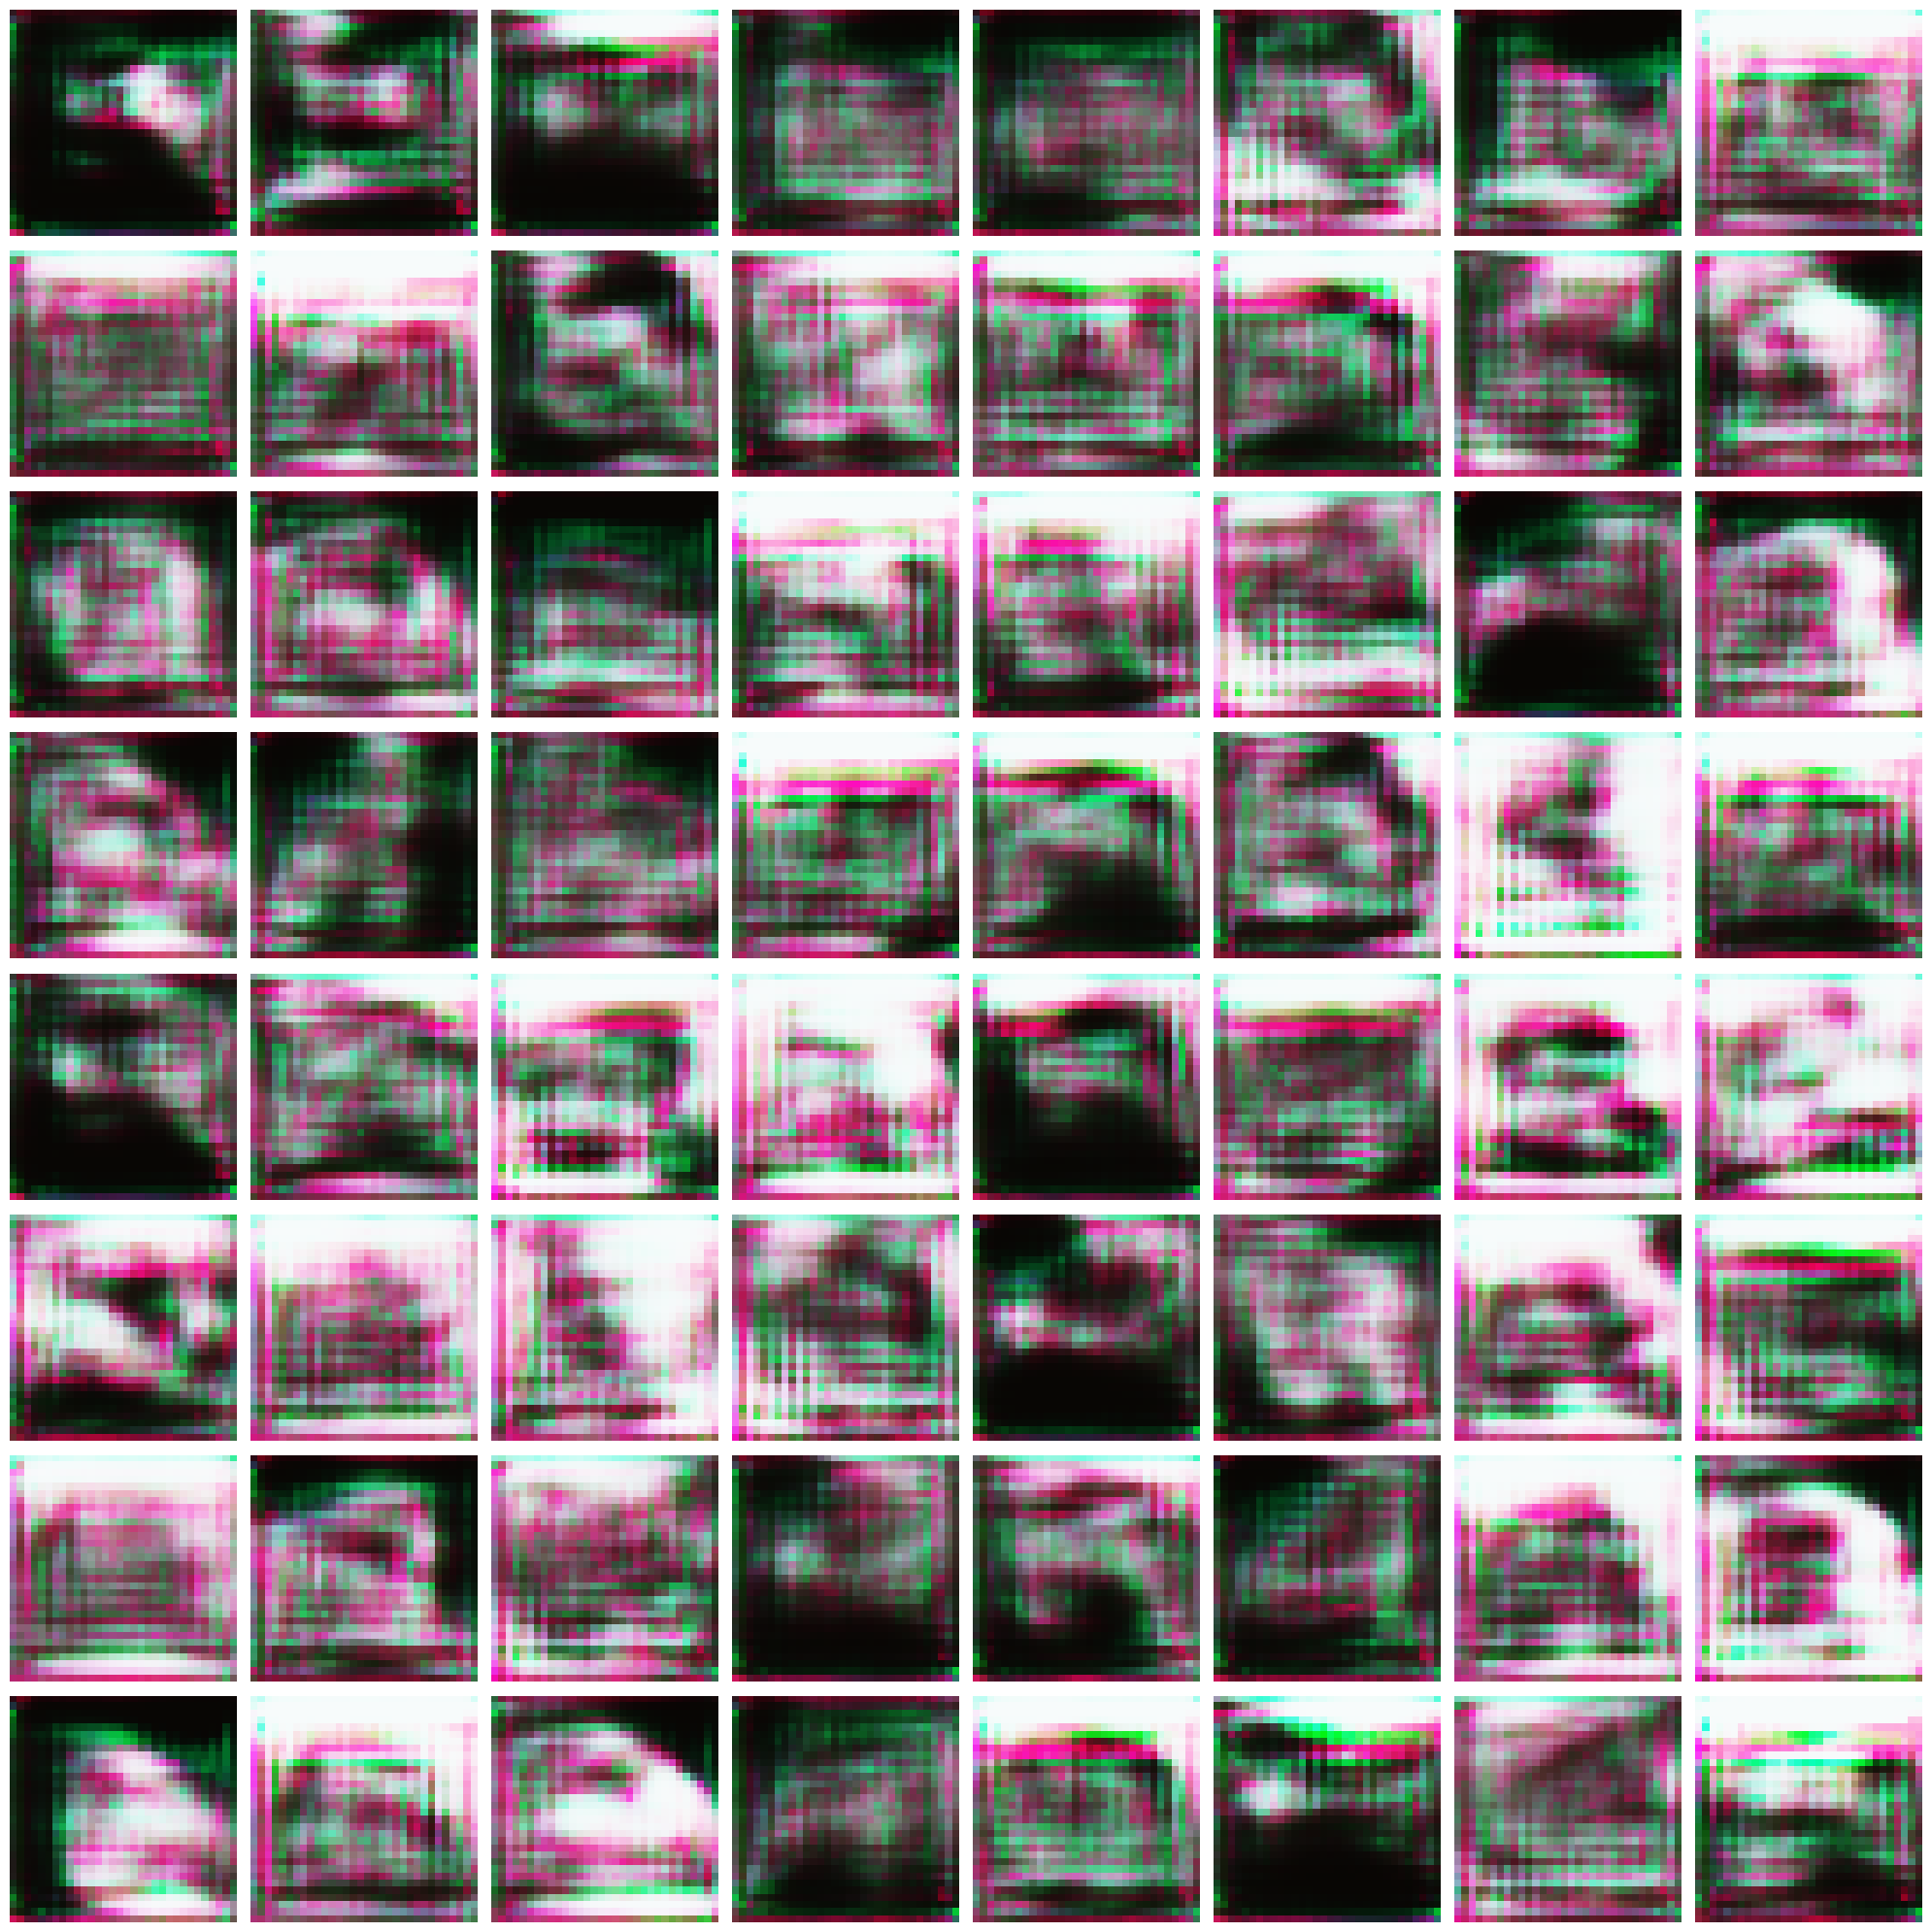

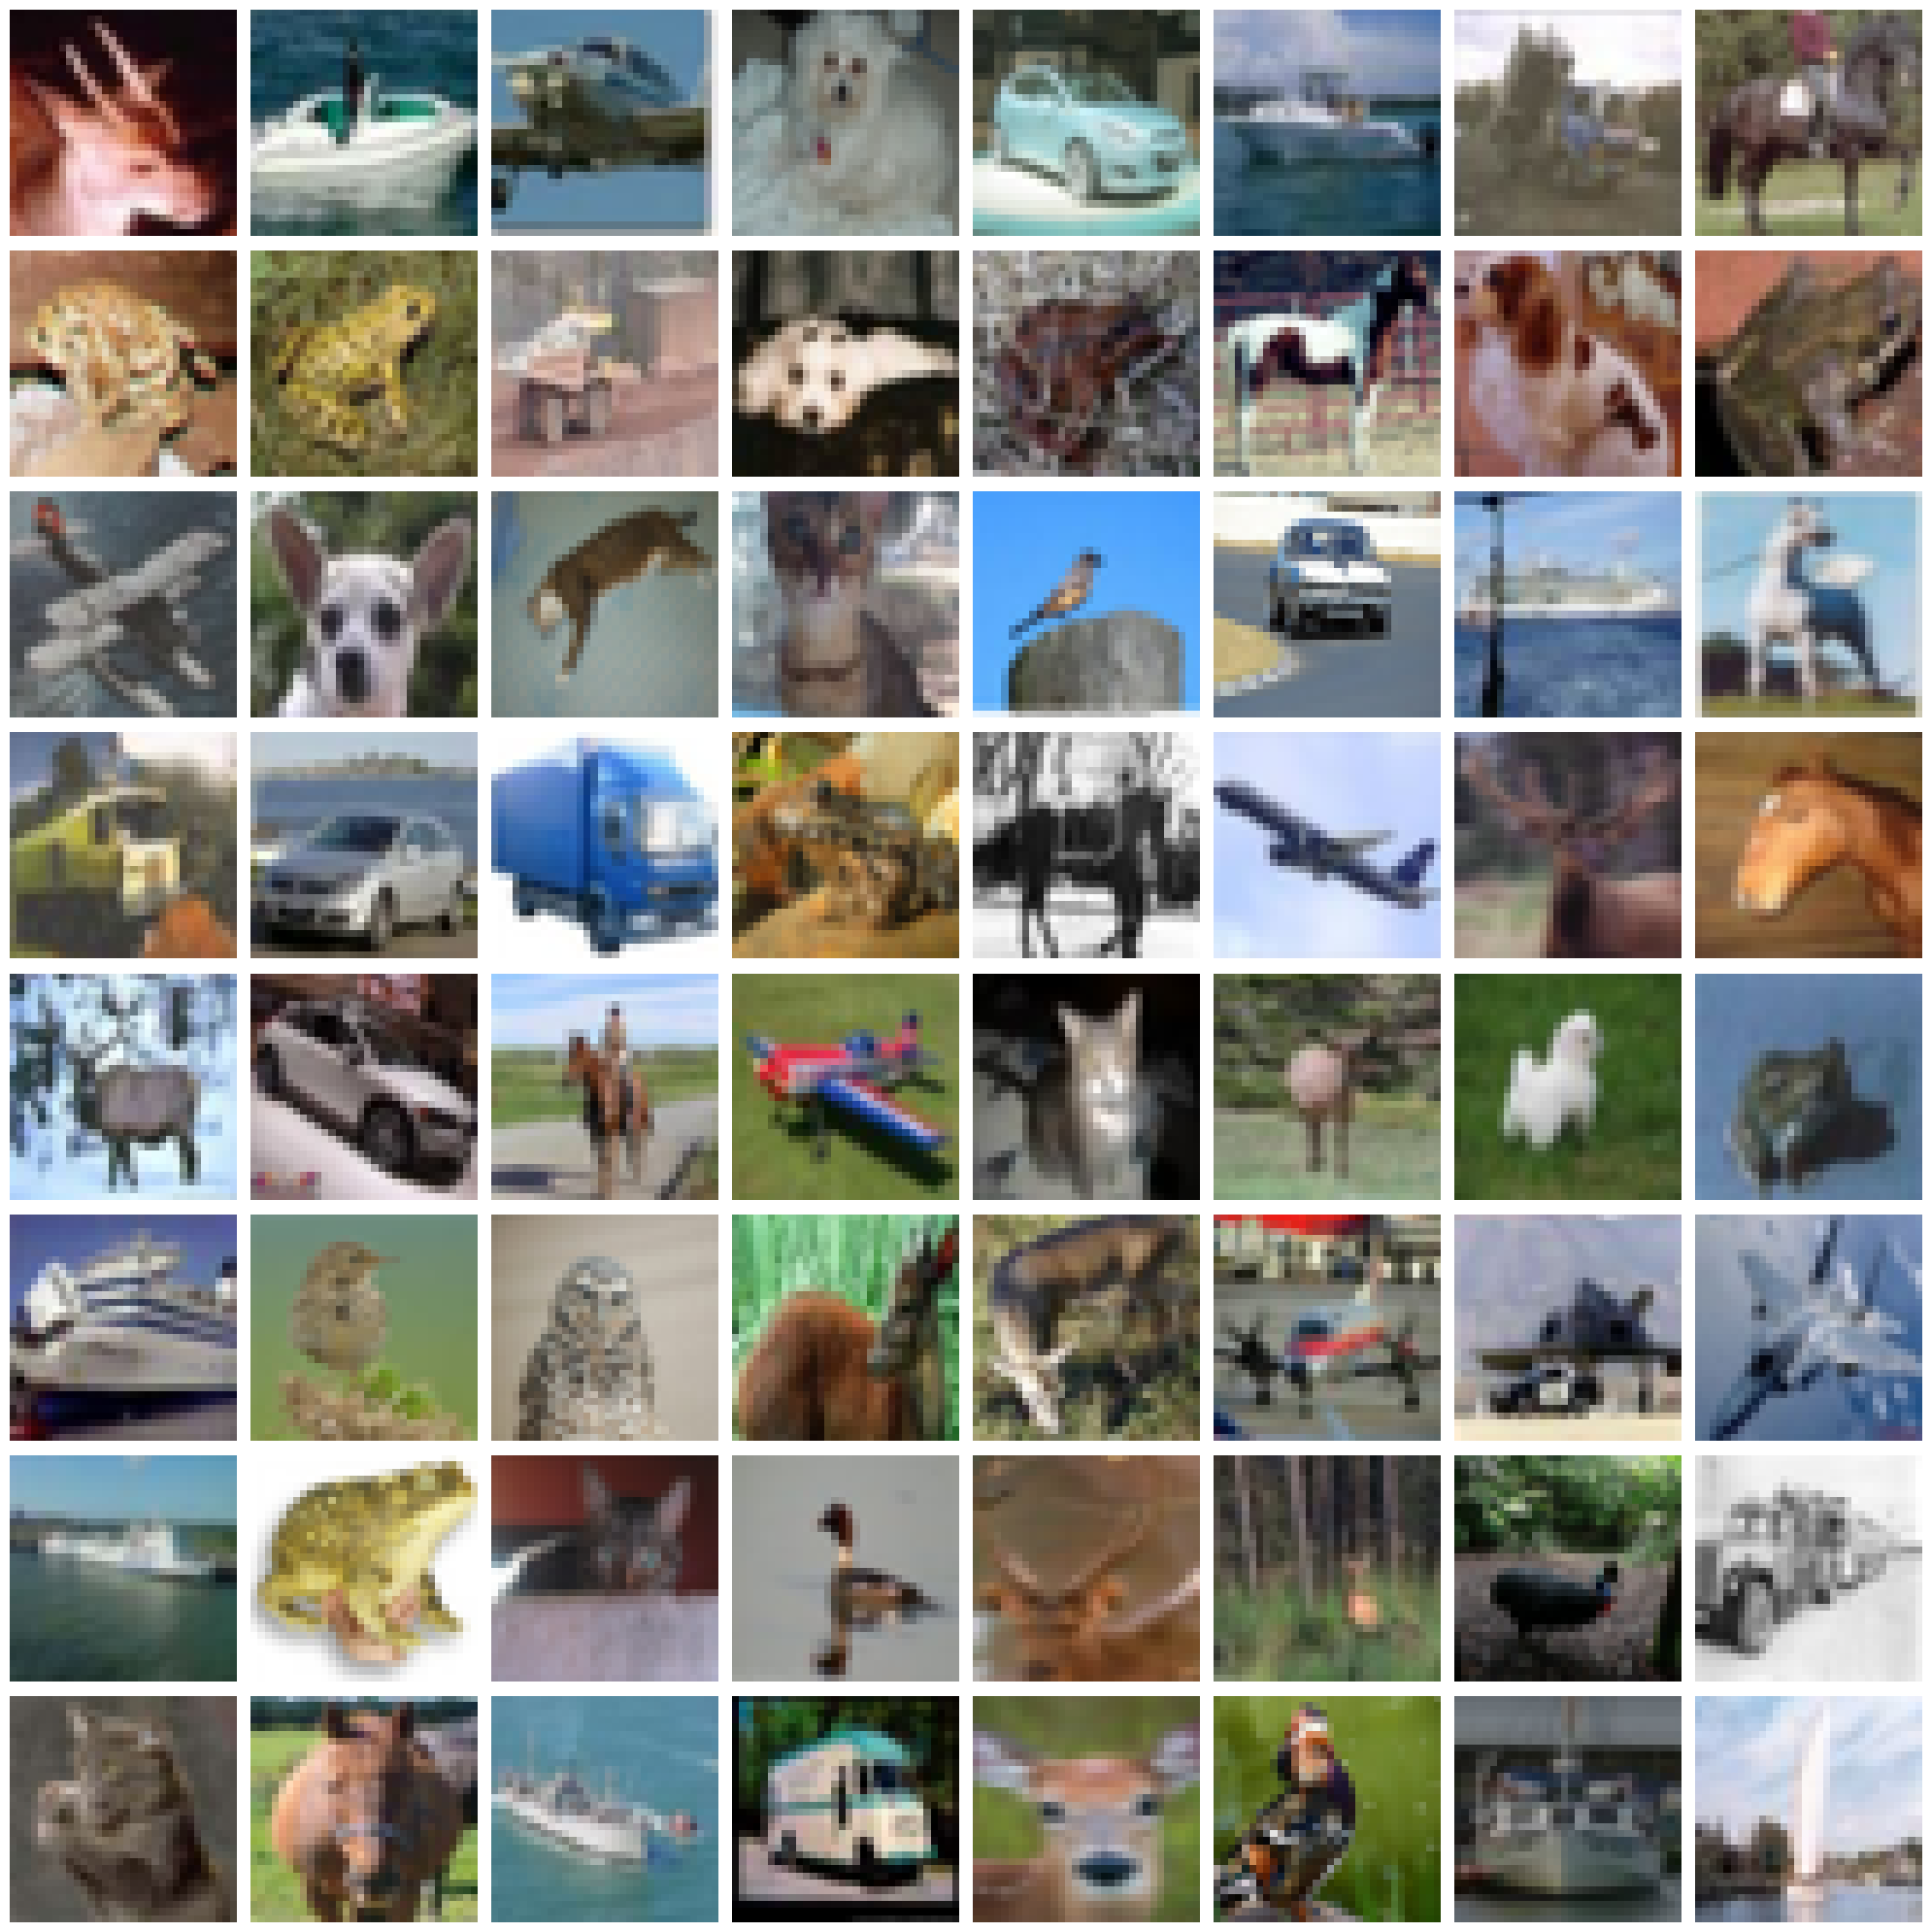

In [6]:
if __name__ == '__main__':
    # load image data
    dataset = load_real_samples()
    cifar10_sslgan = CIFAR10_SSLGAN()
    timer = ElapsedTimer()
    c_loss_history, d_loss1_history, d_loss2_history, g_loss_history = \
       cifar10_sslgan.train(dataset,  n_batch=1024, n_epochs=2, save_interval=10)
    timer.elapsed_time()
    cifar10_sslgan.plot_images(fake=True)
    cifar10_sslgan.plot_images(fake=False, save2file=False)

In [7]:
timer = ElapsedTimer()
c_loss_history, d_loss1_history, d_loss2_history, g_loss_history = \
cifar10_sslgan.train(dataset,  n_batch=1024, n_epochs=2, save_interval=10)
timer.elapsed_time()


n_epochs=2, n_batch=1024, 1/2=512, b/e=48, steps=96
n_steps: 96
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
>10, c[1.430,69%], d1[0.624,67%], d2[0.689,67%], g[0.849,31%]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
>20, c[0.926,69%], d1[0.686,66%], d2[0.626,66%], g[

In [8]:
cifar10_sslgan.SSLGAN.save("SSLGAN_CIFAR10/SSLGAN_CIFAR10_L1L2_FM.h5")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LeakyReLU

def custom_activation(output):
    import tensorflow.keras.backend as K
    logexpsum = K.sum(K.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

def load(self, file_path):
    self.AM = load_model(file_path, custom_objects={
        'LeakyReLU': LeakyReLU,
        'custom_activation': custom_activation
    })
    self.GM = Model(self.AM.input, self.AM.layers[-2].output)
    self.DM = self.AM.layers[-1]
    last_prev_layer = self.DM.layers[-2]
    c_out_layer = Activation('softmax')(last_prev_layer.output)
    self.CM = Model(self.DM.input, c_out_layer)


In [ ]:
cifar10_sslgan.plot_images(fake=True)
cifar10_sslgan.plot_images(fake=False, save2file=False)

In [ ]:
import matplotlib.pyplot as plt

#c_loss_history, d_loss1_history, d_loss2_history, g_loss_history

history = c_loss_history
c_loss= [ elem[0] for elem in history] 
c_acc = [ elem[1] for elem in history] 

history = d_loss1_history
d_loss1= [ elem[0] for elem in history] 
d_acc1 = [ elem[1] for elem in history] 

history = d_loss2_history
d_loss2= [ elem[0] for elem in history] 
d_acc2 = [ elem[1] for elem in history] 

history = g_loss_history
g_loss1= [ elem[0] for elem in history] 
g_acc1 = [ elem[1] for elem in history] 

plt.plot(c_loss, label='Classifier Training Loss')
plt.plot(d_loss1, label='Discriminator Training Loss for Real Data')
plt.plot(d_loss2, label='Discriminator Training Loss for Fake Data')
plt.plot(g_loss, label='Generator Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(c_acc, label='Classifier Training Acc')
plt.plot(d_acc1, label='Discriminator Training Acc for Real Data')
plt.plot(d_acc2, label='Discriminator Training Acc for Fake Data')
plt.plot(g_acc, label='Generator Training Acc')
plt.title('Training Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


In [ ]:
#c_loss_history, d_loss1_history, d_loss2_history, g_loss_history
import pickle
# Define the file path
file_path = "SSLGAN_CIFAR10/c_loss_history"
# Save the list of objects to a file
with open(file_path, 'wb') as file:
    pickle.dump( c_loss_history, file)

# Define the file path
file_path = "SSLGAN_CIFAR10/d_loss1_history"
# Save the list of objects to a file
with open(file_path, 'wb') as file:
    pickle.dump( d_loss1_history, file)

# Define the file path
file_path = "SSLGAN_CIFAR10/d_loss2_history"
# Save the list of objects to a file
with open(file_path, 'wb') as file:
    pickle.dump( d_loss2_history, file)

    # Define the file path
file_path = "SSLGAN_CIFAR10/g_loss_history"
# Save the list of objects to a file
with open(file_path, 'wb') as file:
    pickle.dump( g_loss_history, file)
    

In [ ]:
timer = ElapsedTimer()
d_history, a_history = cifar10_sslgan.train(train_steps=500000, batch_size=1024, save_interval=1000)
timer.elapsed_time()
cifar10_dcgan.plot_images(fake=True)
cifar10_dcgan.plot_images(fake=False, save2file=False)


In [ ]:
!pip install opencv-python

In [12]:
import cv2
import numpy as np


def generate_images(model, fake=False, samples=32, noise=None, noise_dim=100):

    if noise is None:
        noise =tf.random.normal([samples, noise_dim]) # np.random.uniform(-1.0, 1.0, size=[samples, 100])#Or tf.random.normal([batch_size, 100])?

    if fake:
        images = model.generator.predict(noise)
        path="SSLGAN_CIFAR10/FakeImgData/"
    else:
        path="SSLGAN_CIFAR10/RealImgData/"
        i = np.random.randint(0, model.x_train.shape[0], samples)
        images = model.x_train[i, :, :, :]

    os.makedirs(path, exist_ok=True)

    for i in range(images.shape[0]):
        filename = path+ "cifar10_%d.png" % i
        img = ((images[i, :, :, :]+1)*255/2).astype(np.uint8)
        cv2.imwrite(filename, img)

generate_images(cifar10_sslgan,fake=True)
generate_images(cifar10_sslgan,fake=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


In [13]:
import numpy as np
import tensorflow as tf
import os
import pathlib
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from scipy.linalg import sqrtm


# 計算Inception Score（IS）
def calculate_inception_score(images, model, batch_size=32, splits=10):
    preds = []
    n_batches = int(np.ceil(float(len(images)) / float(batch_size)))

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch = images[start_idx:end_idx]
        batch = preprocess_input(batch)
        preds.append(model.predict(batch))

    preds = np.concatenate(preds, axis=0)
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

# 計算Fréchet Inception Distance（FID）
def calculate_fid(real_images, generated_images, model, batch_size=32):
    act1 = model.predict(real_images, batch_size=batch_size)
    act2 = model.predict(generated_images, batch_size=batch_size)
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# 載入Inception模型
def load_inception_model():
    base_model = InceptionV3(include_top=True, pooling='avg', input_shape=(299, 299, 3))
    model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
    return model

# 載入圖像
def load_images(image_paths, image_size=(299, 299)):
    images = []
    for path in image_paths:
        img = Image.open(path)
        img = np.asarray(img.resize(image_size))
        if len(img.shape)==3:
          img = img[:,:,0:3] #discard the alpha dimension
        else:
          color_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
          # Set RGB channels to grayscale values
          color_image[:,:,0] = img
          color_image[:,:,1] = img
          color_image[:,:,2] = img
          img = color_image
        images.append(img)
    return np.array(images)

# 設定圖像路徑
real_image_paths = [ 'SSLGAN_CIFAR10/RealImgData/cifar10_%d.png' % i for i in range(32)]
generated_image_paths =[ 'SSLGAN_CIFAR10/FakeImgData/cifar10_%d.png' % i for i in range(32)]

# 載入Inception模型
inception_model = load_inception_model()

# 載入圖像
real_images = load_images(real_image_paths)
generated_images = load_images(generated_image_paths)

# 計算並輸出Inception Score
is_mean, is_std = calculate_inception_score(generated_images, inception_model)
print("Inception Score: Mean = {}, Std = {}".format(is_mean, is_std))

# 計算並輸出Fréchet Inception Distance
fid = calculate_fid(real_images, generated_images, inception_model)
print("Fréchet Inception Distance:", fid)


2025-04-04 23:46:19.968285: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2410_0', 228 bytes spill stores, 228 bytes spill loads

2025-04-04 23:46:20.013171: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2410', 192 bytes spill stores, 192 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Inception Score: Mean = 1.5565913915634155, Std = 0.19571231305599213
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Fréchet Inception Distance: 0.2065600634113731
